# Pipeline setup in notebook

## Imports

In [1]:
import logging
from queue import Queue, Empty
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet18

In [3]:
input_path = '/Users/gsowell/Desktop/Research/Fourthbrain/Capstone/samsung-capstone/notebooks/img/test_slide_21.png'
input_image = np.array(Image.open(input_path).convert('RGB'))

## Class MyMitosisDetection:

### def __init__(self, path_model, size, batchsize):

In [4]:
# network parameters
path_model_od = '/content/drive/MyDrive/Fourthbrain/Capstone/models/Object Detection/CODAEL_1/CODAEL_OD_v1_run_0_weights.pth'
path_model_cp = '/content/drive/MyDrive/Fourthbrain/Capstone/models/Cell Patch Classifier/CODAEL_1/model_baseline_CODAEL_v0_weights.pth'
size = 512 # size of overlapping patches for object detection
patch_size = 250 # size of cell patches for patch classifier
batchsize = 10
num_classes = 2
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

# dataset parameters
mean = [0.7441, 0.5223, 0.6265]
std = [0.1409, 0.1618, 0.1320]

### def get_model_od(self):

Instantiate Faster RCNN object detection model

In [5]:
def get_model_od(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

  # replace the classifier with a new one, that has
  # num_classes which is user-defined
  # 1 class (mitosis) + background (non-mitosis)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

### def get_model_cp(self):

Instantiate ResNet18 cell patch classifier model

In [6]:
def get_model_cp(num_classes):
  model = resnet18(pretrained=True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, num_classes)
  input_size = 224
  return model

### def load_model_od(self):

Load fine-tuned weights into object detection model

In [7]:
def load_model_od():
  # load pre-trained model
  model_od = get_model_od(num_classes=2)

  mean = torch.FloatTensor([0.7441, 0.5223, 0.6265]).to(device)  # state['data']['normalize']['mean']
  std = torch.FloatTensor([0.1409, 0.1618, 0.1320]).to(device)  # state['data']['normalize']['std']

  # load in fine-tuned weights to model and save to device
  if torch.cuda.is_available():
      print("Model loaded on CUDA")
      model_od.load_state_dict(torch.load(path_model_od))
  else:
      print("Model loaded on CPU")
      model_od.load_state_dict(torch.load(path_model_od, map_location='cpu'))

  model_od.to(device)

  logging.info("Model OD loaded. Mean: {} ; Std: {}".format(mean, std))
  return model_od

### def load_model_cp(self):

Load fine-tuned weight into cell patch classifier model

In [8]:
def load_model_cp():
  model_cp = get_model_cp(num_classes=2)

  mean = torch.FloatTensor([0.7441, 0.5223, 0.6265]).to(device)  # state['data']['normalize']['mean']
  std = torch.FloatTensor([0.1409, 0.1618, 0.1320]).to(device)  # state['data']['normalize']['std']

  # load in fine-tuned weights to model and save to device
  if torch.cuda.is_available():
      print("Model loaded on CUDA")
      model_cp.load_state_dict(torch.load(path_model_cp))
  else:
      print("Model loaded on CPU")
      model_cp.load_state_dict(torch.load(path_model_cp, map_location='cpu'))

  model_cp.to(device)

  logging.info("Model CP loaded. Mean: {} ; Std: {}".format(mean, std))
  return model_cp

### def patches(self, input_image):

Take input image and generate coordinates for overlapping crops

In [9]:
def patches(input_image):
  queue_patches = Queue()
  img_dimensions = input_image.shape

  n_patches = 0
  # create overlapping patches for the whole image
  for x in np.arange(0, img_dimensions[1], int(0.9 * size)):
      for y in np.arange(0, img_dimensions[0], int(0.9 * size)):
          # last patch shall reach just up to the last pixel
          if (x+size>img_dimensions[1]):
              x = img_dimensions[1]-512

          if (y+size>img_dimensions[0]):
              y = img_dimensions[0]-512

          queue_patches.put((0, int(x), int(y), input_image))
          n_patches += 1

  n_batches = int(np.ceil(n_patches / batchsize))

  return n_batches, queue_patches

### def get_batch(self, queue_patches, size):

Take a queue with specified patch size (512 for OD, 250 for CP) to create PyTorch batch for object detection and cell patch classifier

In [10]:
def get_batch(queue_patches, size):
  batch_images = np.zeros((batchsize, 3, size, size))
  batch_x = np.zeros(batchsize, dtype=int)
  batch_y = np.zeros(batchsize, dtype=int)
  for i_batch in range(batchsize):
      if queue_patches.qsize() > 0:
          status, batch_x[i_batch], batch_y[i_batch], image = queue_patches.get()
          x_start, y_start = int(batch_x[i_batch]), int(batch_y[i_batch])

          cur_patch = image[y_start:y_start+size, x_start:x_start+size] / 255.
          batch_images[i_batch] = cur_patch.transpose(2, 0, 1)[0:3]
      else:
          batch_images = batch_images[:i_batch]
          batch_x = batch_x[:i_batch]
          batch_y = batch_y[:i_batch]
          break
  torch_batch = torch.from_numpy(batch_images.astype(np.float32, copy=False)).to(device)

  #for p in range(torch_batch.shape[0]):
    #torch_batch[p] = transforms.Normalize(mean, std)(torch_batch[p])
  return torch_batch, batch_x, batch_y

### def postprocess_patch(self, cur_bbox_pred, cur_class_pred, x_real, y_real)

Get the best predicted bounding box and score for one patch

In [11]:
def postprocess_patch(cur_bbox_pred, cur_label_pred, cur_score_pred, x_real, y_real):
  # take the first bounding box prediction (i.e., highest score)
  # in future could implement non-maxima supression for sophisticated bounding box selection
  if len(cur_bbox_pred) > 0:
    # copy torch tensors to cpu if running CUDA
    best_bbox = cur_bbox_pred[0].cpu()
    best_label = cur_label_pred[0].cpu()
    best_score = cur_score_pred[0].cpu()
    # coordinates of bbox on the patch (lu = (0,0))
    xmin = best_bbox[0]
    ymin = best_bbox[1]
    xmax = best_bbox[2]
    ymax = best_bbox[3]
    # store bbox relative to real lu coordinates on original input image
    cur_patch_box = np.array([xmin + x_real, ymin + y_real, xmax + x_real, ymax + y_real, best_label, best_score])

  else: # if no predictions were made, return empty list
    cur_patch_box = []

  return cur_patch_box

### def object_detection(self, input_image):

Run object detection on the overlapping image crops

In [12]:
def object_detection(input_image):
  # might load model in main script
  #model_od = load_od_model() # load fine-tuned model
  model_od.eval()

  n_batches, queue_patches = patches(input_image) # get overlapping patch coordinates

  image_boxes = []
  with torch.no_grad():
    # loop through batches
    for _ in tqdm(range(n_batches), desc='Processing an image'):
      torch_batch, batch_x, batch_y = get_batch(queue_patches, size)
      # perform transforms
      torch_batch = transforms.Normalize(mean, std)(torch_batch)
      output = model_od(torch_batch)

      # loop through each patch in the batch
      for b in range(torch_batch.shape[0]):
        # get coordinates of lu on original input image
        x_real = batch_x[b]
        y_real = batch_y[b]
        # get bounding boxes, labels, and scores
        cur_bbox_pred = output[b]['boxes']
        cur_label_pred = output[b]['labels']
        cur_score_pred = output[b]['scores']
        # get best bounding box
        cur_patch_box = postprocess_patch(cur_bbox_pred, cur_label_pred, cur_score_pred, x_real, y_real)
        if len(cur_patch_box) > 0:
          image_boxes.append(cur_patch_box)
  return np.array(image_boxes)

### def cell_patches(self, input_image):

Generate coordinates of 250 px patches centered around detections from def object_detection

In [13]:
def cell_patches(input_image):
  queue_cells = Queue()

  # input image dims
  h = input_image.shape[0]
  w = input_image.shape[1]

  # get detections from OD model
  detections = object_detection(input_image)

  n_patches = 0
  for idx, detection in enumerate(detections):
    # coordinates of bbox on the input image
    xmin = detections[idx][0]
    ymin = detections[idx][1]
    xmax = detections[idx][2]
    ymax = detections[idx][3]

    # detection centroid
    x = (xmin + xmax)/2
    y = (ymin + ymax)/2

    # upper left corner
    lu_x = int(x - patch_size/2)
    lu_y = int(y - patch_size/2)

    # ensure image crops are not out of bounds
    # if they are, will create in-bounds non-centered patch
    # constrain x-coordinates
    if lu_x < 0:
      lu_x = 0
    elif x + patch_size/2 > w:
      lu_x = w - patch_size
    
    # constrain y-coordinates
    if lu_y < 0:
      lu_y = 0
    elif y + patch_size/2 > h:
      lu_y = h - patch_size

    queue_cells.put((0, int(lu_x), int(lu_y), input_image))
    n_patches+=1
    n_batches = int(np.ceil(n_patches / batchsize))
  return n_batches, queue_cells

### def gradcam(self, img):

Generate heatmap for a 250 px cell patch when running def patch_classifier

In [14]:
def gradcam(img):
    model_cp.eval()
    model_cp.zero_grad()

    img = img.cpu() # copy image to cpu if using CUDA
    img = img.unsqueeze(0)


    def __extract(grad):
        global feature_grad
        feature_grad = grad
    # get features from the last convolutional layer
    img = img.to(device) # write image to device
    x = model_cp.conv1(img)
    x = model_cp.bn1(x)
    x = model_cp.relu(x)
    x = model_cp.maxpool(x)
    x = model_cp.layer1(x)
    x = model_cp.layer2(x)
    x = model_cp.layer3(x)
    x = model_cp.layer4(x)
    features = x

    # hook for the gradients
    def __extract_grad(grad):
        global feature_grad
        feature_grad = grad
    features.register_hook(__extract_grad)

    # get the output from the whole VGG architecture
    x = model_cp.avgpool(x)
    x = x.view(x.size(0), -1)
    output = model_cp.fc(x)
    pred = torch.argmax(output).item()
    #print(pred)

    # get the gradient of the output
    output[:, pred].backward()

    # pool the gradients across the channels
    pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

    # weight the channels with the corresponding gradients
    # (L_Grad-CAM = alpha * A)
    features = features.detach()
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_grad[i] 

    # average the channels and create an heatmap
    # ReLU(L_Grad-CAM)
    features = features.cpu() # copy features to cpu if using CUDA
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # normalization for plotting
    heatmap = heatmap / torch.max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

### def patch_classifier(self, input_image):

In [15]:
def patch_classifier(input_image):
  # might load model in main script
  #model_cp = load_model_cp() # load fine-tuned model
  model_cp.eval()

  n_batches, queue_cells = cell_patches(input_image) # get overlapping patch coordinates

  predictions = []
  heatmaps = []
  coordinates = {'x': [],
                  'y': []}

    # loop through batches
  for _ in tqdm(range(n_batches), desc='Processing an image'):
    torch_batch, batch_x, batch_y = get_batch(queue_cells, patch_size)
    # record coordinates of lu on original/input image
    coordinates['x'] = coordinates['x'] + batch_x.tolist()
    coordinates['y'] = coordinates['y'] + batch_y.tolist()
    # perform transforms
    torch_batch = transforms.Resize(224)(torch_batch)
    torch_batch = transforms.Normalize(mean, std)(torch_batch)
    # predictions
    with torch.no_grad():
      output = model_cp(torch_batch)
      _, preds = torch.max(output, 1)
      predictions = predictions + preds.tolist()

    # get heatmaps
    for idx, img in enumerate(torch_batch):
      heatmap = gradcam(img)
      heatmaps.append(heatmap)
      
  return predictions, heatmaps, coordinates

### def heatmap(self, input_image, predictions, heatmaps, coordinates):

Takes predictions, heatmaps, and coordinates from def patch_classifier and overlays heatmaps of predicted mitosis over the input image

In [16]:
def heatmap(input_image, predictions, heatmaps, coordinates):
    mask = np.zeros(input_image.shape)
    for idx, prediction in enumerate(predictions):
        if prediction == 0:
            # upper left corner of cell patch/heatmap
            x_start = coordinates['x'][idx]
            y_start = coordinates['y'][idx]
            
            # heatmap
            heatmap = heatmaps[idx]
            heatmap = cv2.resize(heatmap, (250, 250))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            mask[y_start:y_start+250, x_start:x_start+250, :] = heatmap

    superimposed_img = input_image + mask
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img

In [17]:
%%time
model_od = load_model_od()
model_cp = load_model_cp()
predictions, heatmaps, coordinates = patch_classifier(input_image)
superimposed_img = heatmap(input_image, predictions, heatmaps, coordinates)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Model loaded on CUDA


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Model loaded on CUDA


Processing an image: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


CPU times: user 22.8 s, sys: 2.84 s, total: 25.6 s
Wall time: 46.6 s


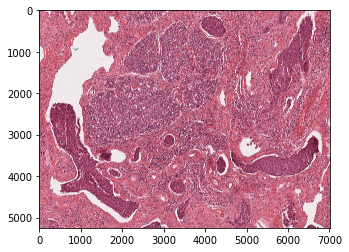

In [18]:
plt.imshow(input_image)

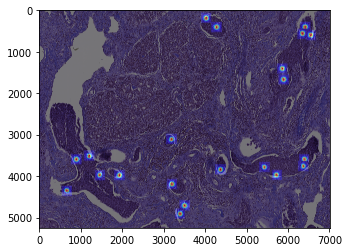

In [19]:
plt.imshow(superimposed_img)